# Exploring the UTx000 Extension Beacon Data
(Known as BPEACE2 in the [GH repo](https://github.com/intelligent-environments-lab/utx000))

In [128]:
import warnings
warnings.filterwarnings('ignore')

# Post-Calibration
With access to higher-grade instruments, we start to look at the possibility of post-calibrating the sensors to get more-reliable results.

## Process
The process for post-calibration is as follows:
1. **Determine Offset** (if any): Some of the sensors have a baseline that is a few (or more) units off from the true baseline. An initial _background_ calibration event should be done/used to correct the sensor to the right baseline. The offsets are saved in a file that is used when reading in the values from a certain study. 
2. 

## Package Import

In [129]:
import os
import sys
sys.path.append('../')

from src.features import build_features
from src.visualization import visualize
from src.reports import make_report
from src.calibration import run_calibration

%load_ext autoreload
%autoreload 2

import pandas as pd
import numpy as np

from datetime import datetime, timedelta

import math
import statsmodels.api as sm

import matplotlib.pyplot as plt
import seaborn as sns
import matplotlib.dates as mdates
from matplotlib.colors import ListedColormap, LinearSegmentedColormap

The autoreload extension is already loaded. To reload it, use:
  %reload_ext autoreload


# Data Import
In the following cells, we grab the relevant data for the calibration events:
1. Background 2
 - **Start**: datetime(2020,12,28,11,12,0)
 - **End**: datetime(2020,12,28,12,12,0)
 - **Beacons**: [1, 4, 5, 9, 10, 12, 13, 14, 15, 16, 17, 18, 19, 21, 22, 23, 24, 25, 26, 28, 29, 30, 32, 34, 36, 38, 40, 44, 46, 48]
2. Candle 1
 - **Start**: datetime(2020,12,30,10,20,0)
 - **End**: datetime(2020,12,30,12,25,0)
 - **Beacons**: [1, 4, 5, 9, 10, 12, 13, 14, 15, 16, 17, 18, 19, 21, 22, 23, 24, 25, 26, 27, 28, 29, 30, 31, 32, 34, 36, 38, 40, 44, 46, 48]
3. Background 3
 - **Start**: datetime(2020,12,30,12,40,0)
 - **End**: datetime(2020,12,31,12,40,0)
 - **Beacons**: [1, 4, 5, 9, 10, 12, 13, 14, 15, 16, 17, 18, 19, 21, 22, 23, 24, 25, 26, 27, 28, 29, 30, 31, 32, 34, 36, 38, 40, 44, 46, 48]
4. Candle 2
 - **Start**: datetime(2020,12,31,13,0,0)
 - **End**: datetime(2021,1,1,13,0,0)
 - **Beacons**: [1, 4, 5, 9, 10, 12, 13, 14, 15, 16, 17, 18, 19, 21, 22, 23, 24, 25, 26, 27, 28, 29, 30, 31, 32, 34, 36, 38, 40, 44, 46, 48]
 

In [154]:
c = run_calibration.Calibration(datetime(2020,12,30,12,40,0),datetime(2020,12,31,12,40,0),"../data/")

## Beacons
We have to grab the raw data from the beacons during the various calibration events. We can borrow from the ```process_beacon.py``` from the ```make_dataset.py``` source file.

In [155]:
beacon = c.get_beacon_data([1, 4, 5, 9, 10, 12, 13, 14, 15, 16, 17, 18, 19, 21, 22, 23, 24, 25, 27, 28, 29, 30, 31, 32, 34, 36, 38, 40, 44, 46, 48])

## Reference Instruments
All data are saved as dataframes in a dictionary indexed by the pollutant type

In [156]:
ref = {}
for pollutant, f in zip(["pm_number","pm_concentration","no","no2","co2"],[c.get_pm_ref,c.get_pm_ref,c.get_no_ref,c.get_no2_ref,c.get_co2_ref]):
    print("reading for", pollutant)
    ref[pollutant] = f(f"{pollutant}_{c.date}.csv")

reading for pm_number
reading for pm_concentration
reading for no
reading for no2
reading for co2


# Base Visualization
Visually comparing measurements

## Inspection of Reference Measurements

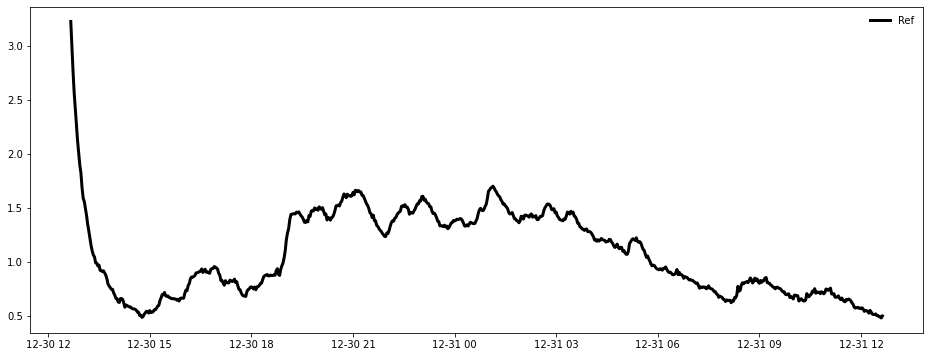

In [157]:
#c.inspect(ref["pm_concentration"][["PM_2p5"]])
c.inspect(ref["no2"])
#c.inspect(beacon[["PM_N_2p5","Beacon"]],timeseries=False)

## Inspection of Beacon Measurements

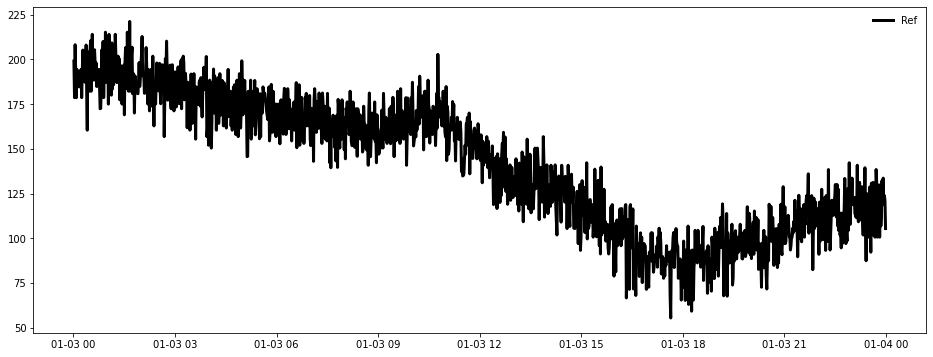

In [158]:
df = pd.read_csv("../data/raw/bpeace2/beacon/B24/adafruit/b24_2021-01-03.csv",index_col=0,parse_dates=True)
c.inspect(df[["NO2"]])

# Analysis
In this section, we take a look at correcting the low-cost sensors to the reference machines in three ways:
1. Constant/Offset
2. Linear Regression
3. Random Forest

The following sections are first broken down by pollutant and then by method.

In [159]:
from sklearn import linear_model
from sklearn.metrics import mean_squared_error, r2_score

## NO2
NO2 is measured on the Beacon by the [SPEC DGS NO2](https://www.spec-sensors.com/wp-content/uploads/2017/01/DGS-NO2-968-043_9-6-17.pdf) sensor. The specifications are listed below:

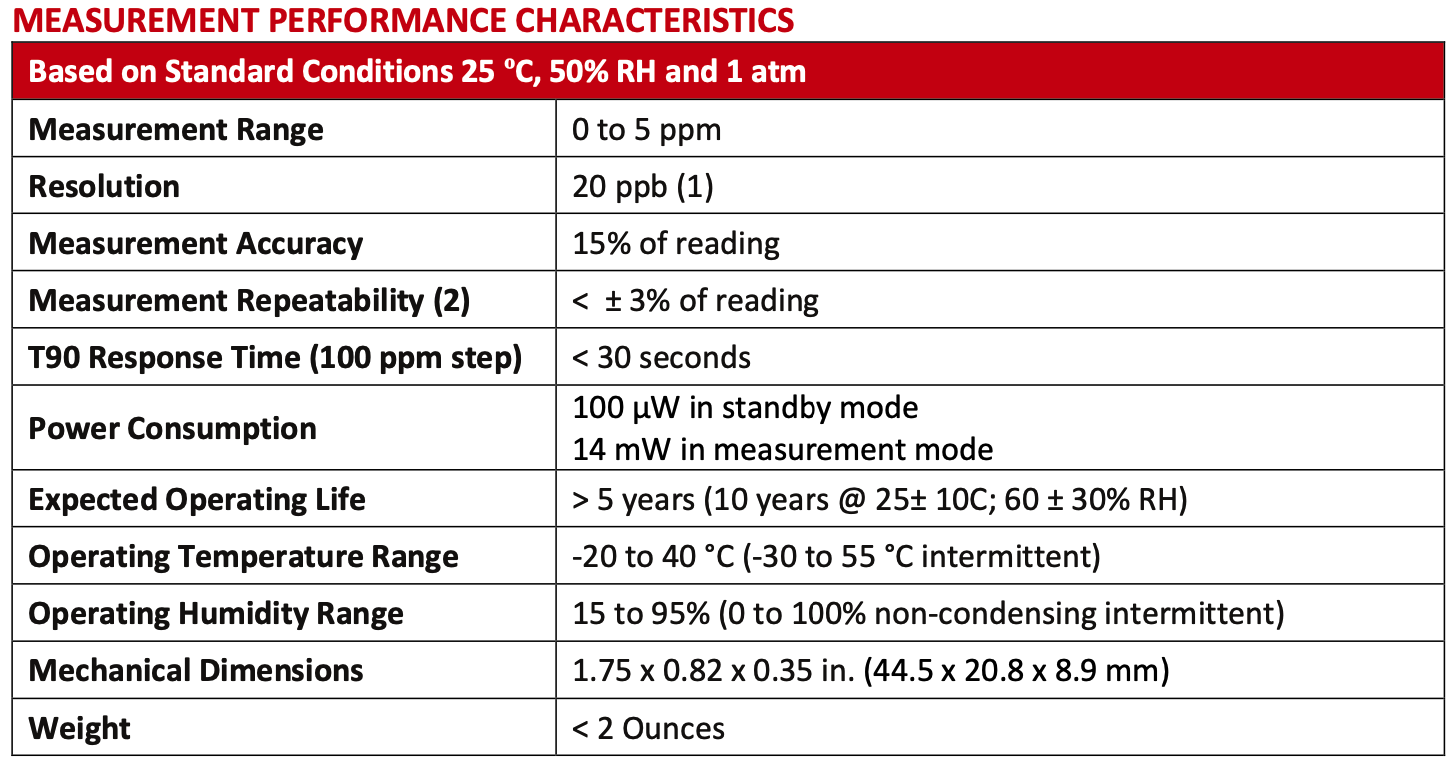

It is also worthwile to note that the sensor is sensitive to other pollutants:

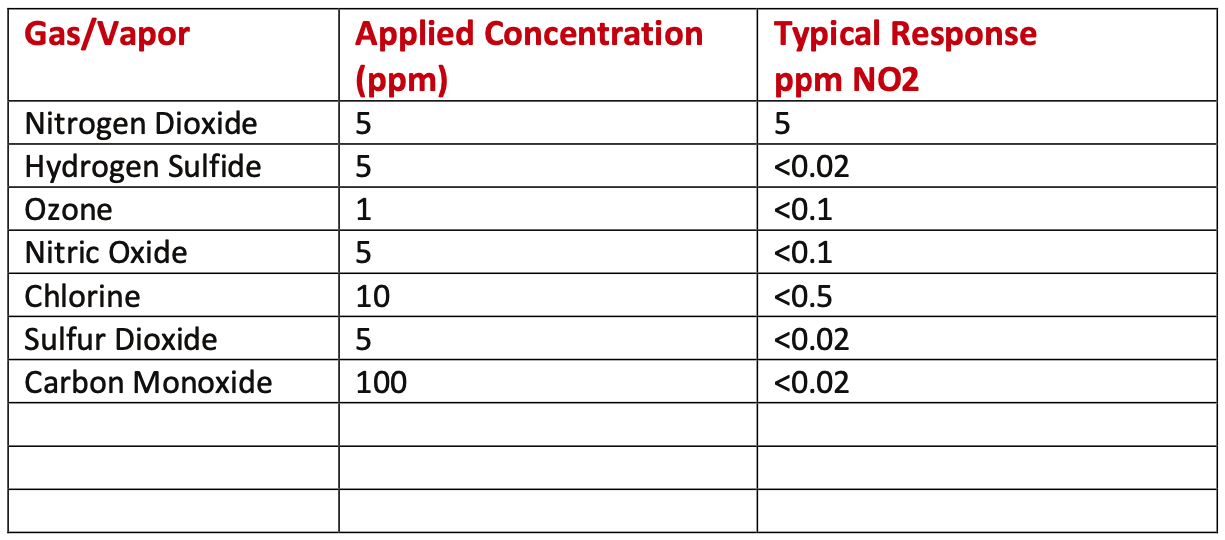

Comparing the reference to the beacons, we can see that a few of the beacons are reading incredibly high, while the remainder seem to measure consistenly low values between 50 and 150 ppb. 

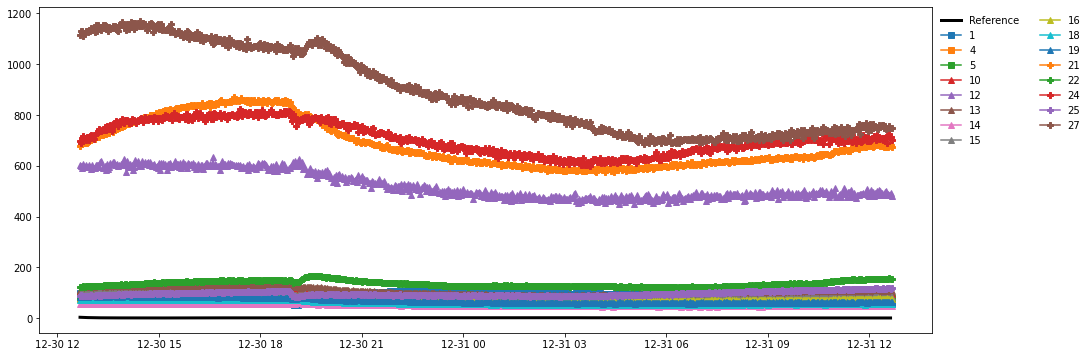

In [160]:
c.compare_time_series(ref["no2"],beacon[["NO2","Beacon"]])

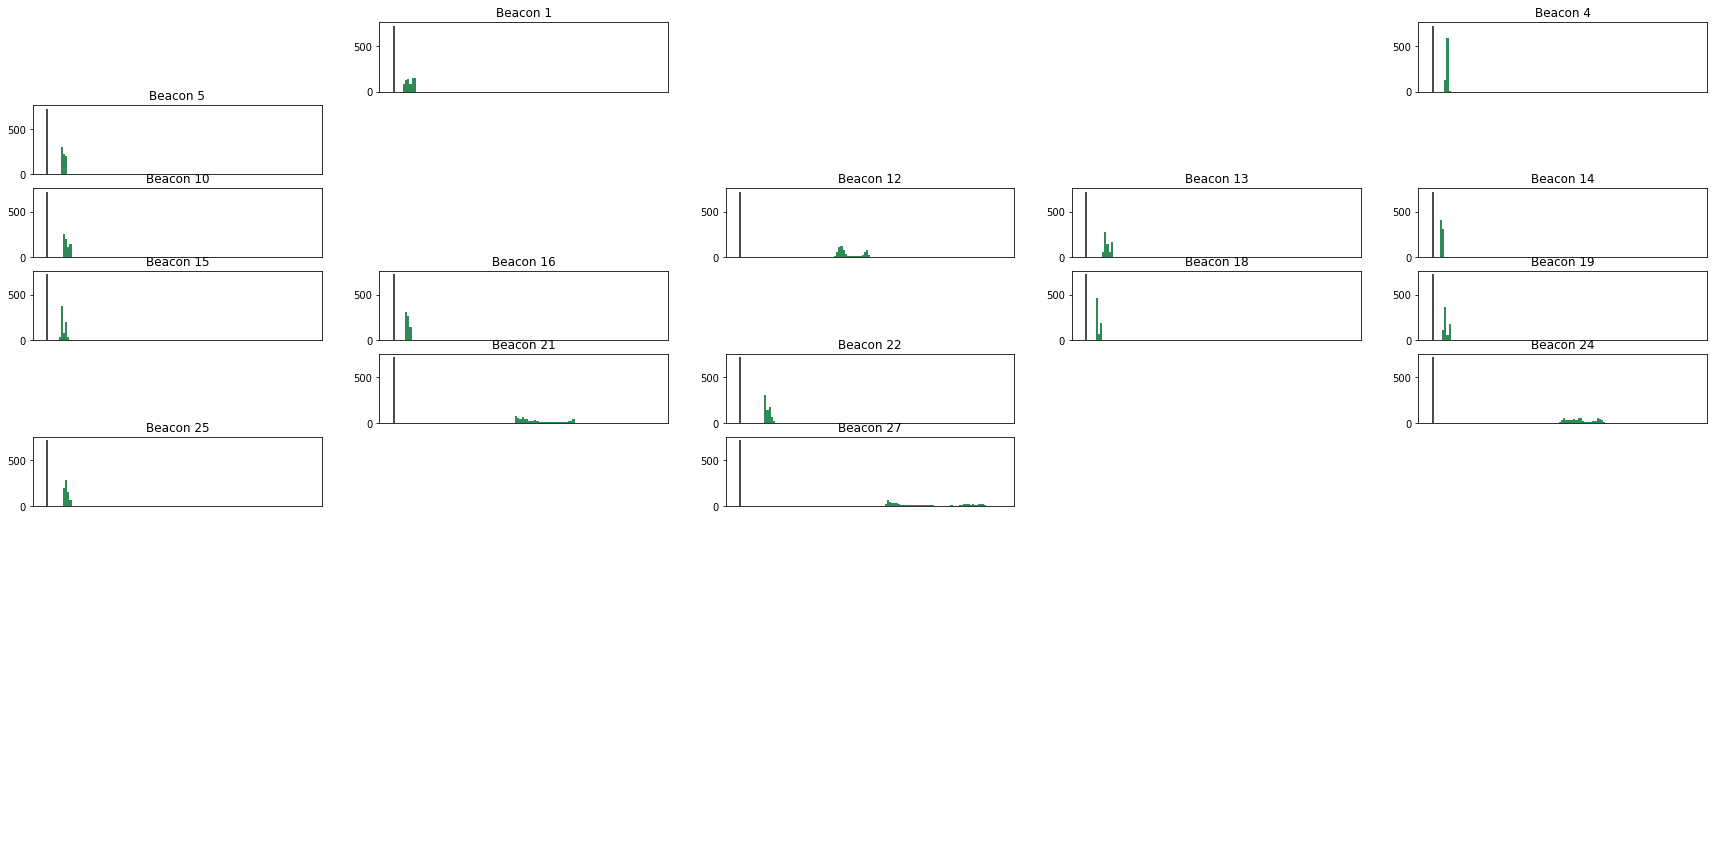

In [161]:
c.compare_histogram(ref["no2"],beacon[["NO2","Beacon"]],bins=np.arange(0,1250,10))

### Constant/Offset
The simplest method, and one that might show promise for this sensor, is simply to offset the measurement by a constant. We start by looking at the differences between each beacon with an NO2 sensor and the reference machine.

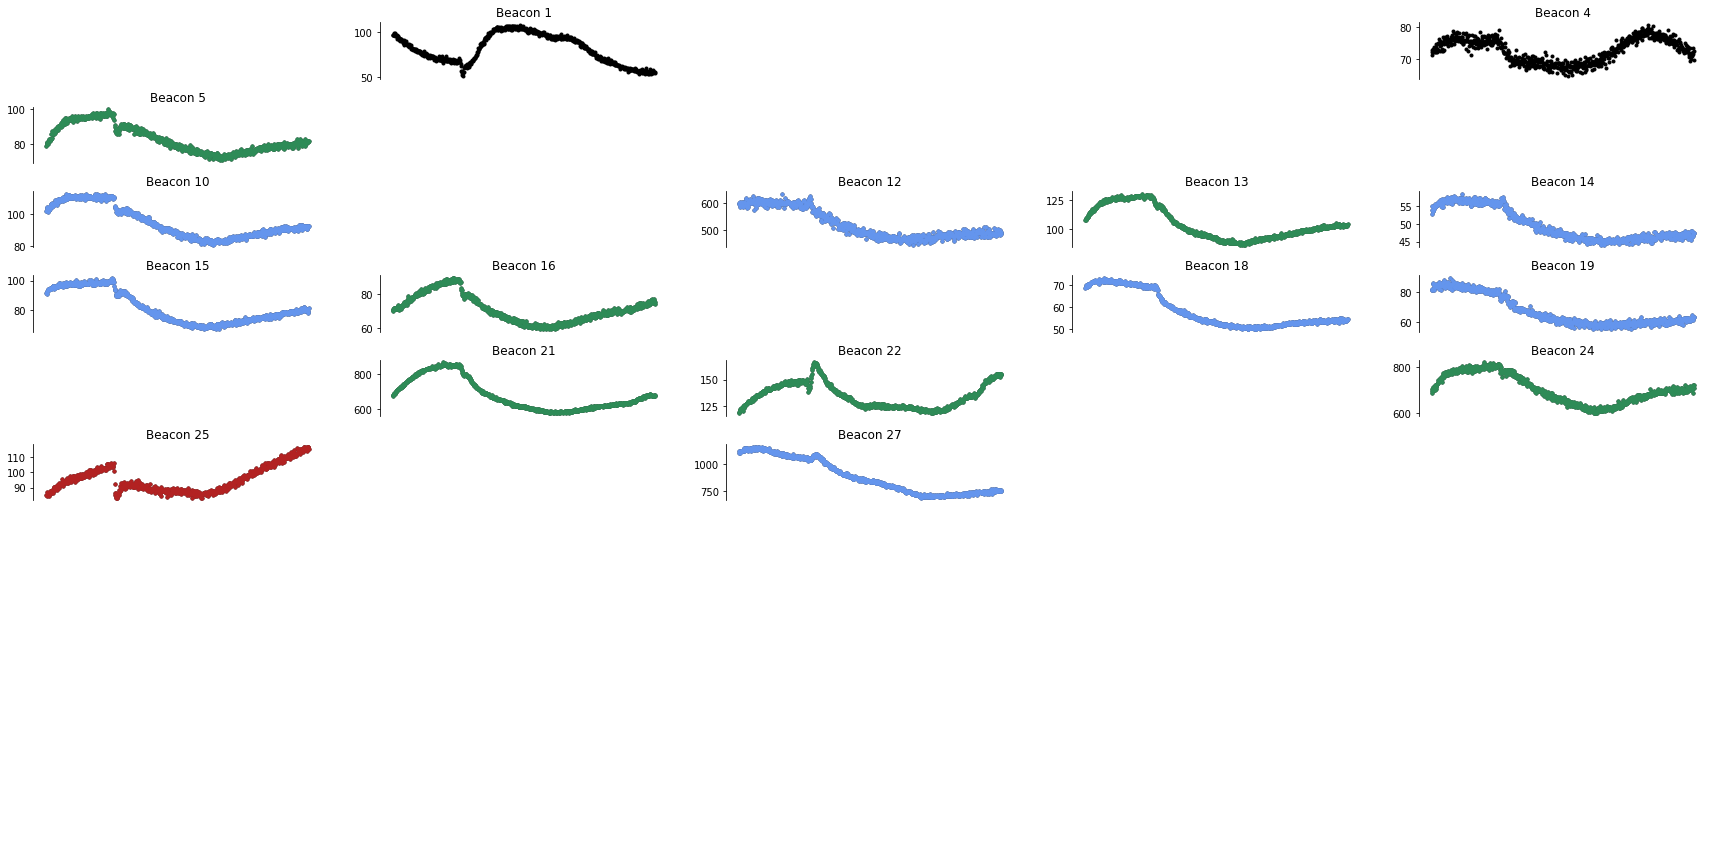

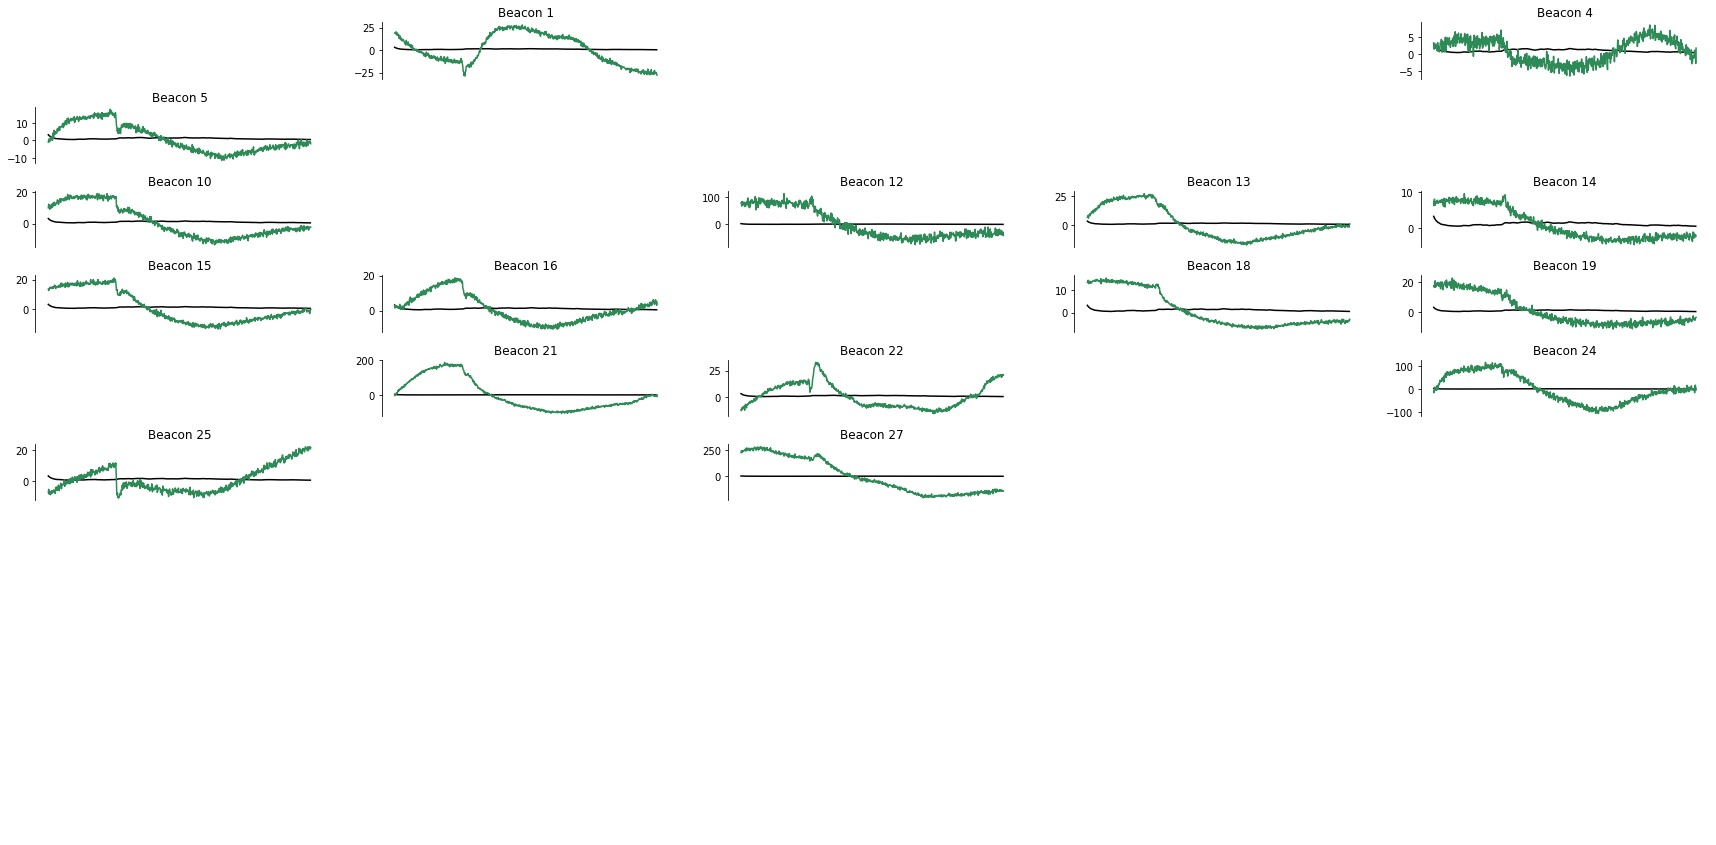

In [169]:
no2_offset = c.offset(ref, beacon, "no2", "NO2", [[5,13,16,21,22,24],[10,12,14,15,18,19,27],[25,26]],save_to_file=True)

Based on the results, it does not seem like there is a good constant offset that we can apply to correct the data. In fact, many of the beacons seem to exhibit the same pattern and are colored accordingly.

### Linear Regression
We can run linear regression for each of the beacons to determine how we can best correct our data.

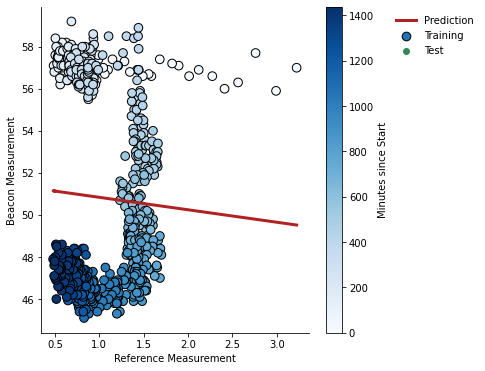

In [139]:
df = beacon[beacon["Beacon"] == 14]
df_ref = ref["no2"]
m = c.regression(df_ref[["Concentration"]],df[["NO2"]])

### Random Forest
Random forests have shown success in recent articles calibrating low cost sensors.

## Particulate Matter - Mass
The [Sensirion SPS30](https://www.sensirion.com/fileadmin/user_upload/customers/sensirion/Dokumente/9.6_Particulate_Matter/Datasheets/Sensirion_PM_Sensors_SPS30_Datasheet.pdf) PM sensor is capable of measuring PM1, PM2.5, and PM10, but we focus on PM2.5 in this section, however the values are easily changed by swapping the following cell to the appropiate value.

In [140]:
# set size to one of ["1","2p5","10"] for the corresponding size
size = "2p5"

Specifications regarding the mass concentrations for the SPS30 sensor are below:

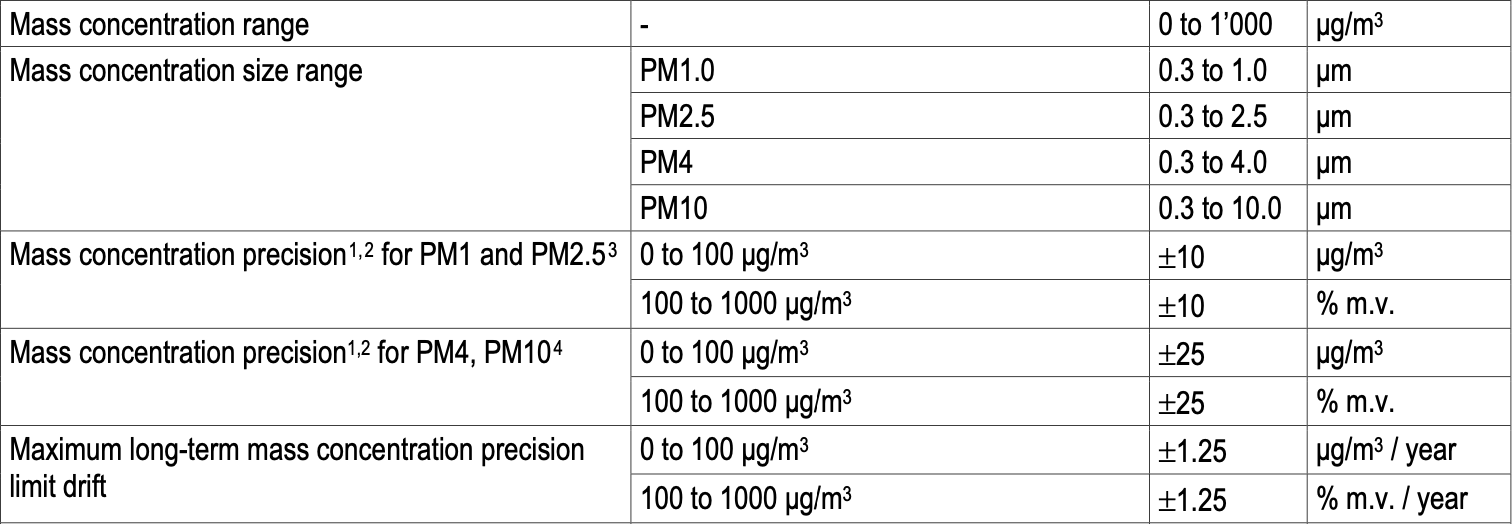

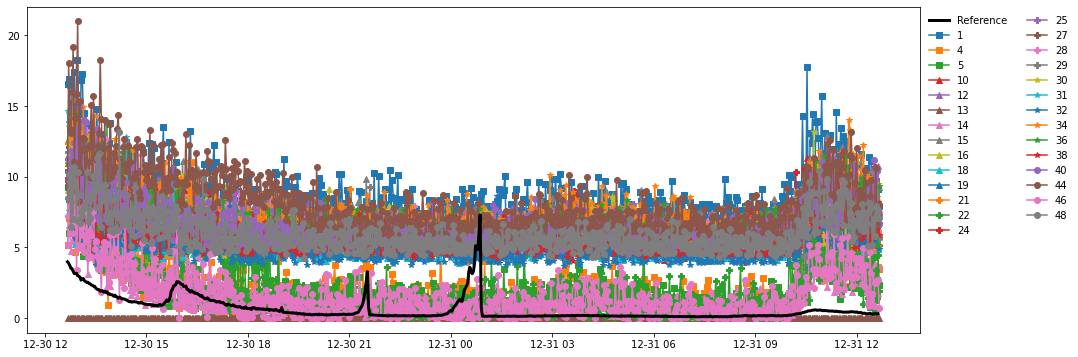

In [164]:
c.compare_time_series(ref["pm_concentration"][[f"PM_{size}"]],beacon[[f"PM_C_{size}","Beacon"]])

In [ ]:
c.compare_histogram(ref["pm_concentration"][[f"PM_{size}"]],beacon[[f"PM_C_{size}","Beacon"]],bins=np.arange(0,21,1))

### Constant/Offset
Based on the above figure, it seems quite clear that a few of the PM sensors have a baseline a few units above zero. So in addition to adding a calibration algorithm, we must include a constant correction. 

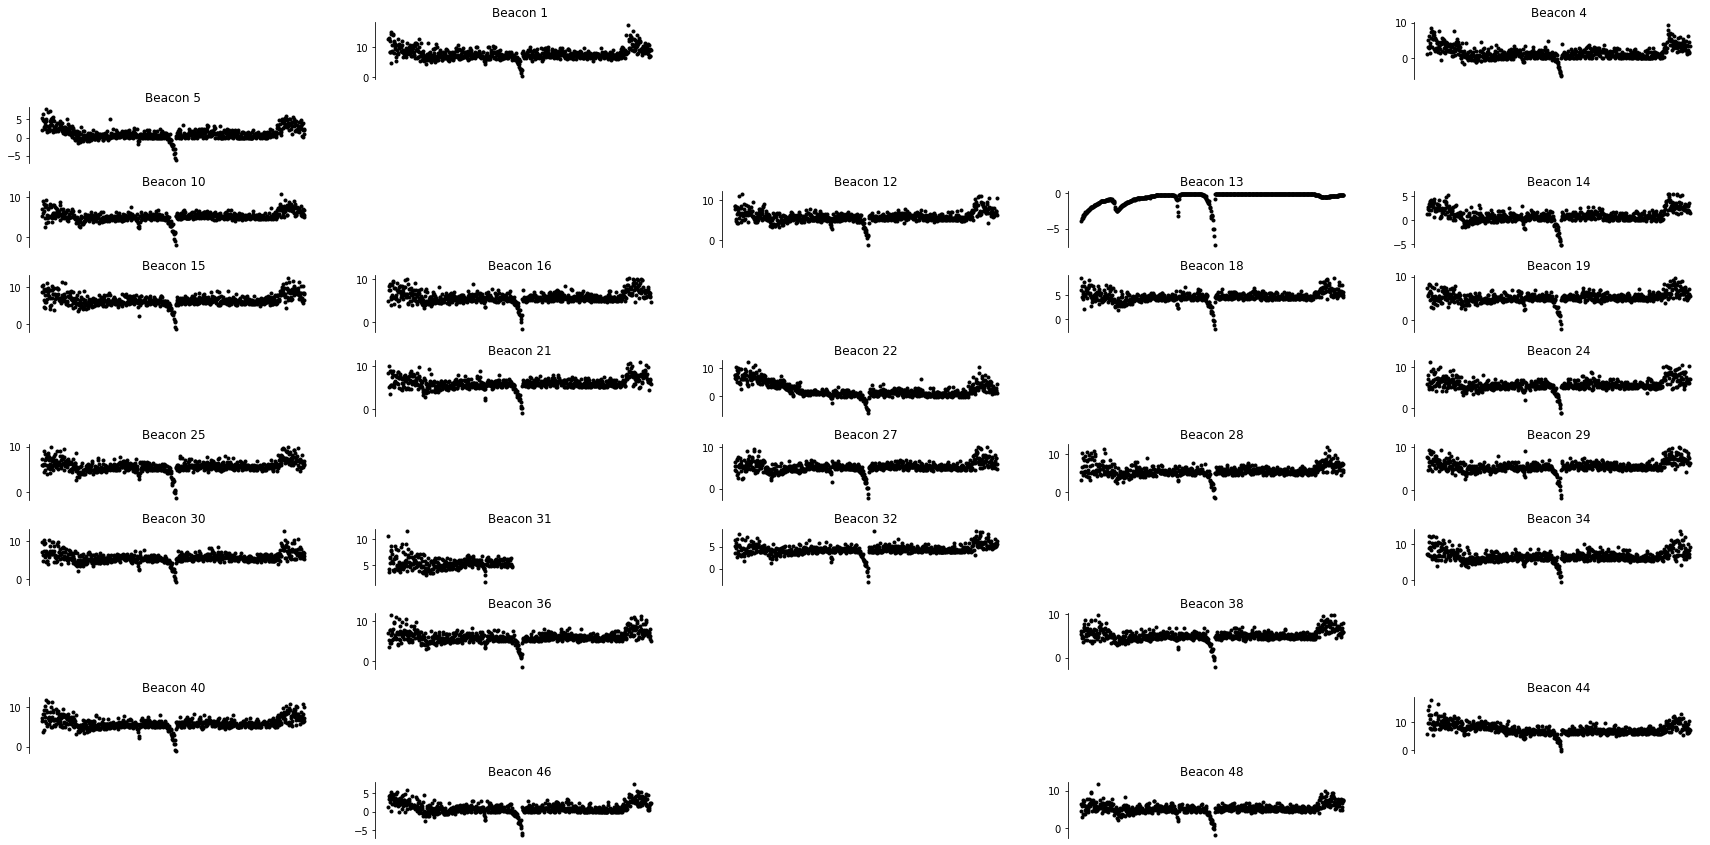

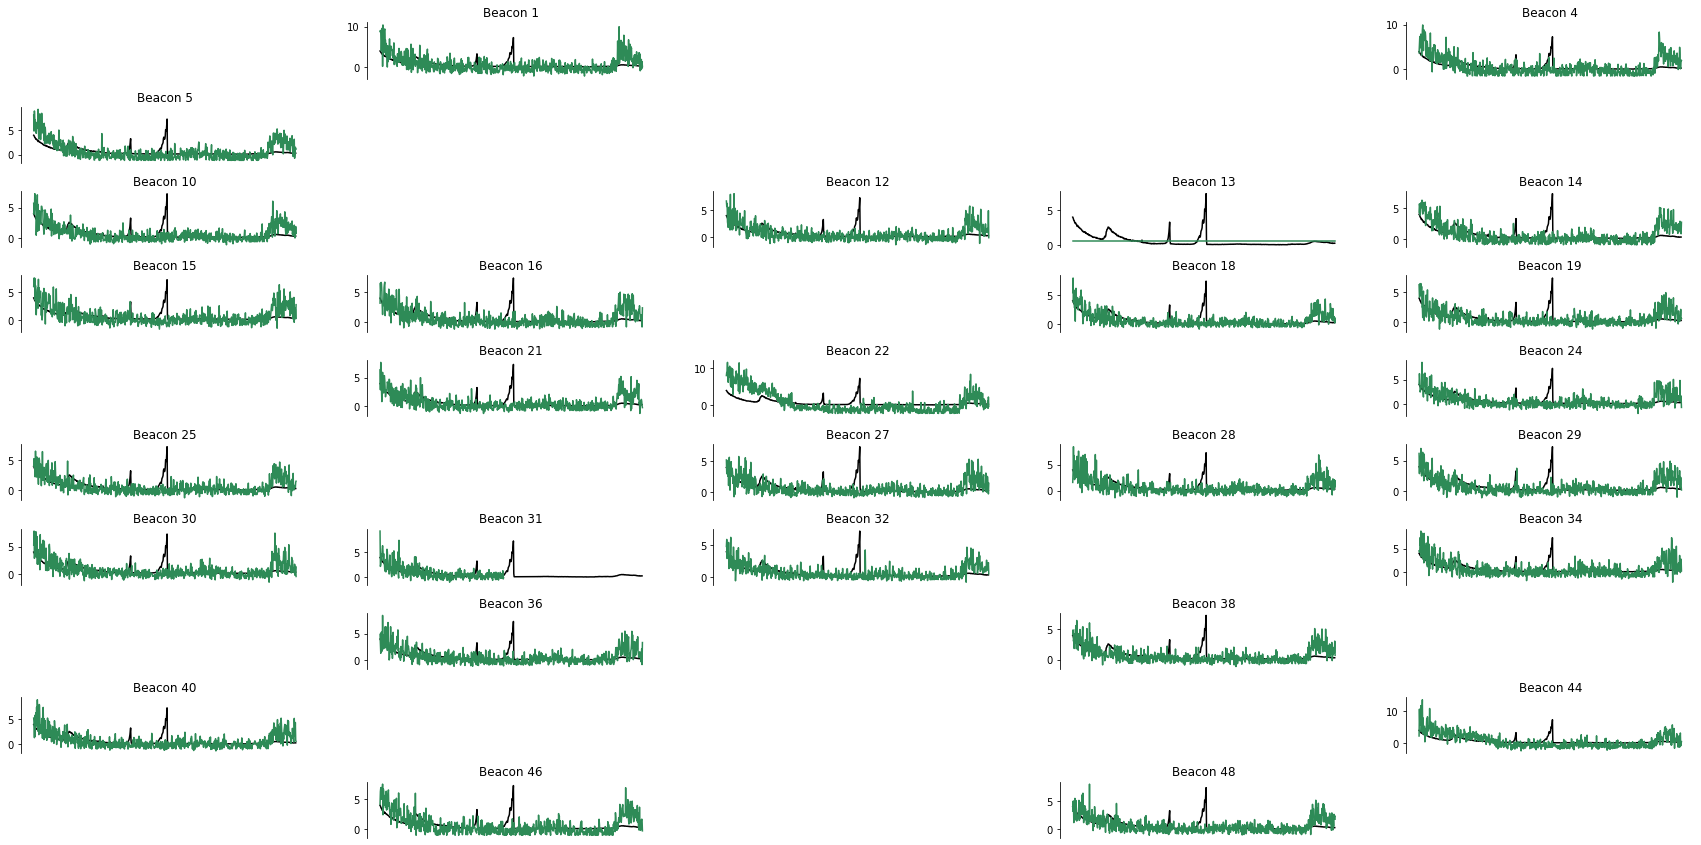

In [168]:
pm_mass = ref["pm_concentration"]
pm_mass["Concentration"] = pm_mass[f"PM_{size}"]
ref["pm_concentration"] = pm_mass
pm_mass_offset = c.offset(ref, beacon, "pm_concentration", f"PM_C_{size}",save_to_file=True)

## Particulate Matter - Number
Now we look at the number concentrations from [Sensirion SPS30](https://www.sensirion.com/fileadmin/user_upload/customers/sensirion/Dokumente/9.6_Particulate_Matter/Datasheets/Sensirion_PM_Sensors_SPS30_Datasheet.pdf) PM sensor to see if the relationship to the reference machine is stronger - the specifications on the number concentrations:

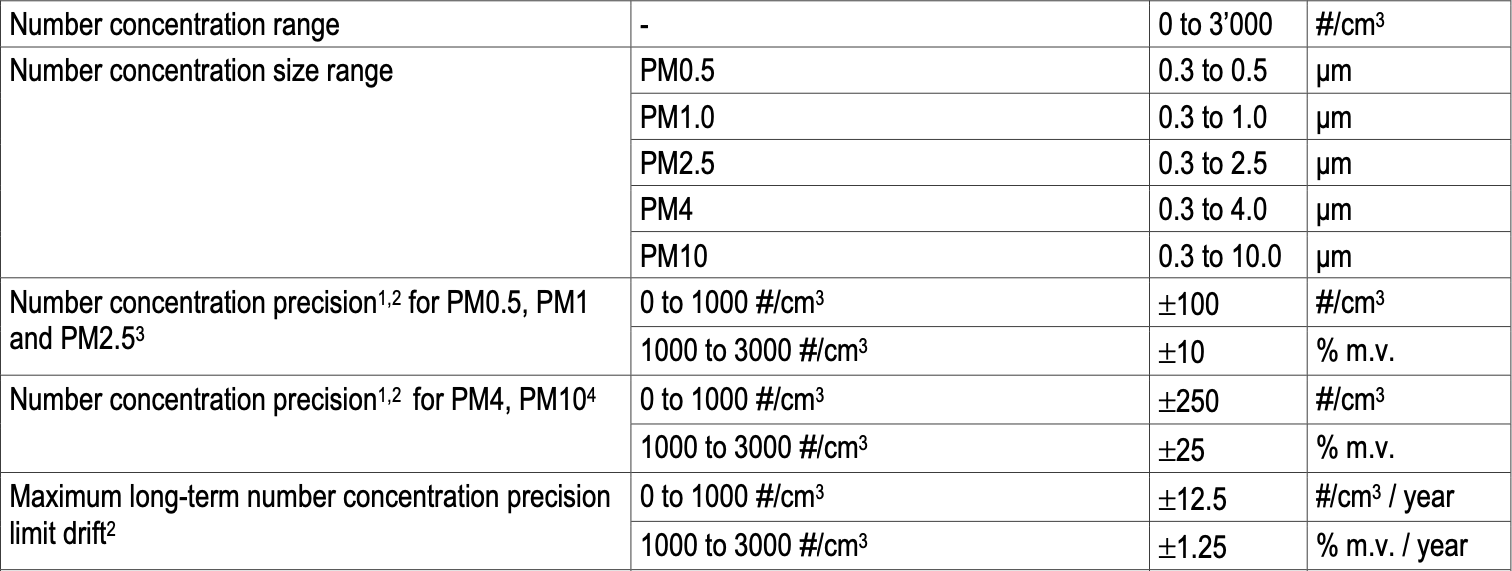

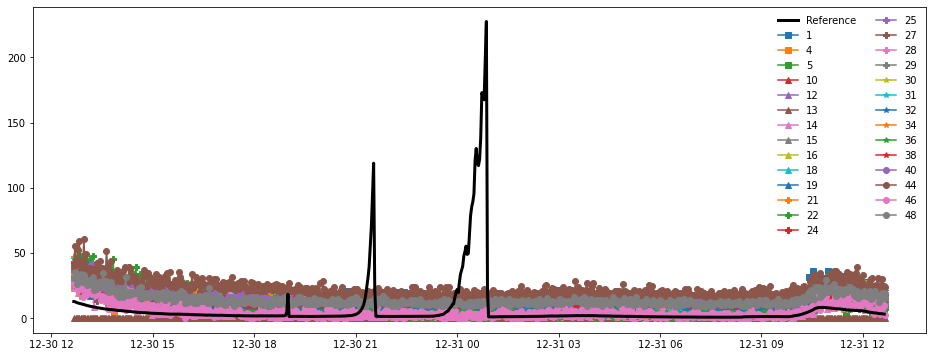

In [144]:
c.compare_time_series(ref["pm_number"][["PM_2p5"]],beacon[["PM_N_2p5","Beacon"]])

## Carbon Dioxide

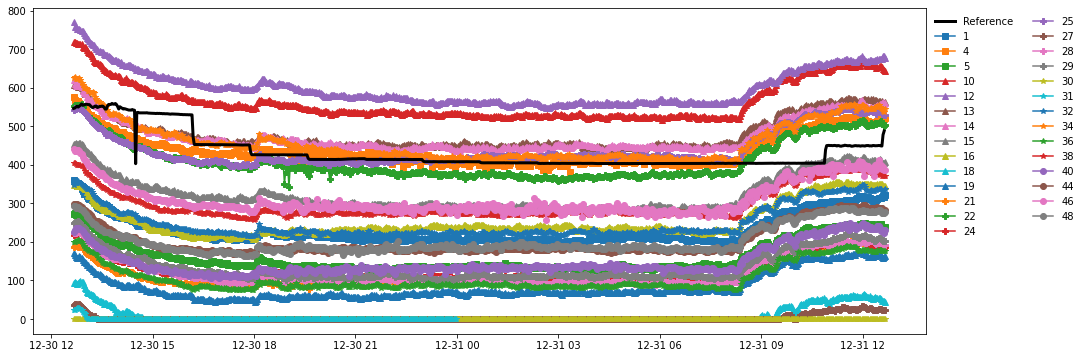

In [145]:
c.compare_time_series(ref["co2"],beacon[["CO2","Beacon"]])

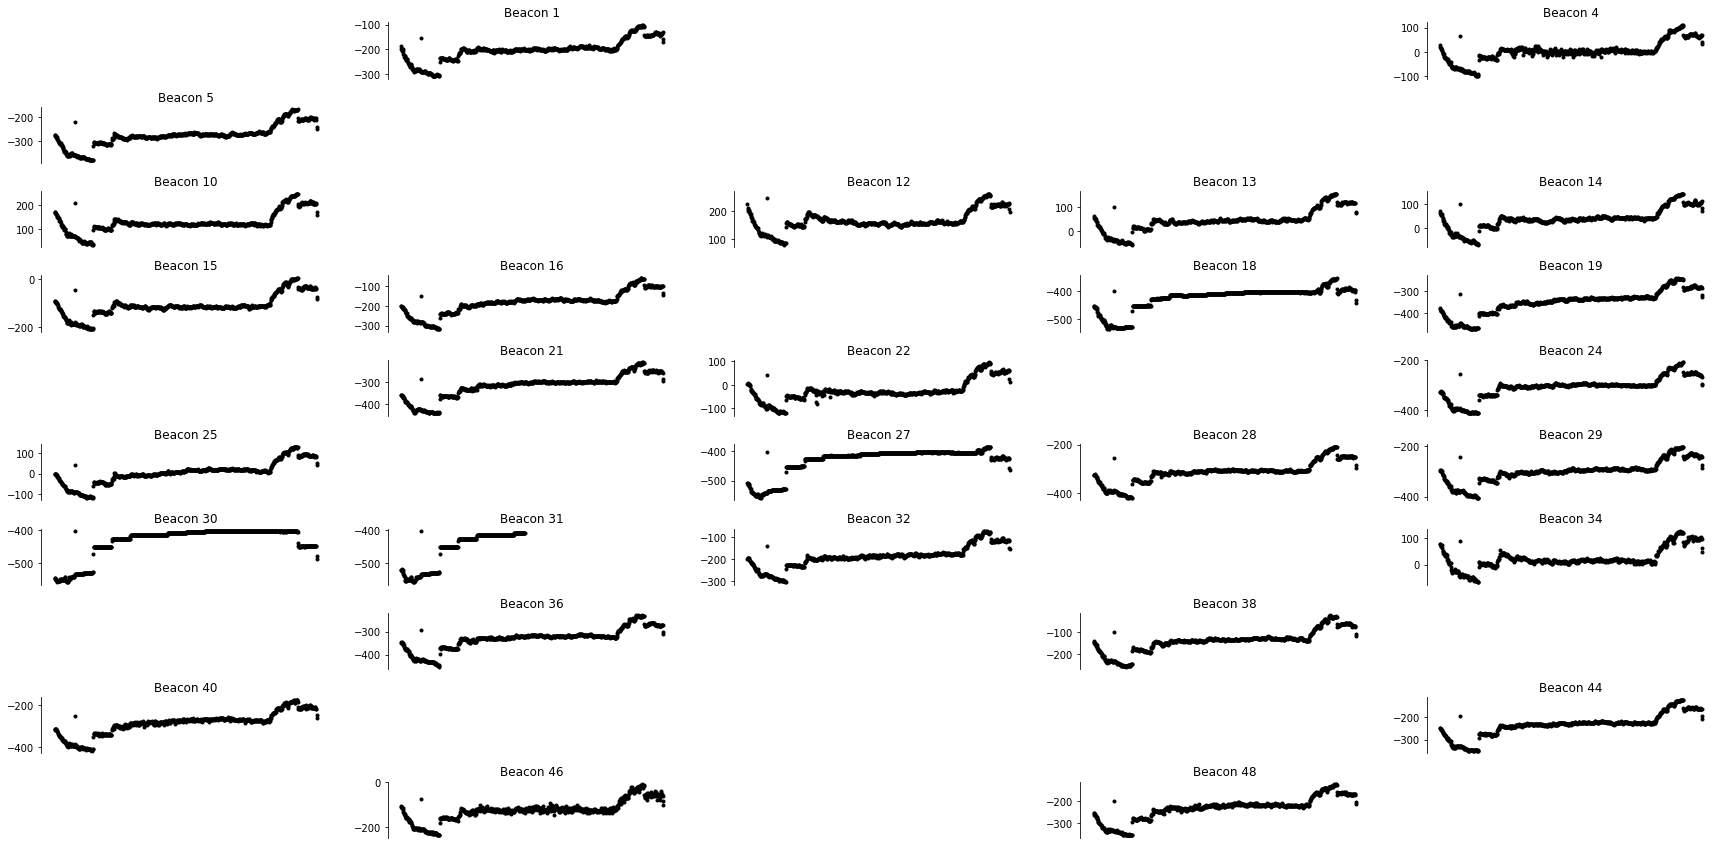

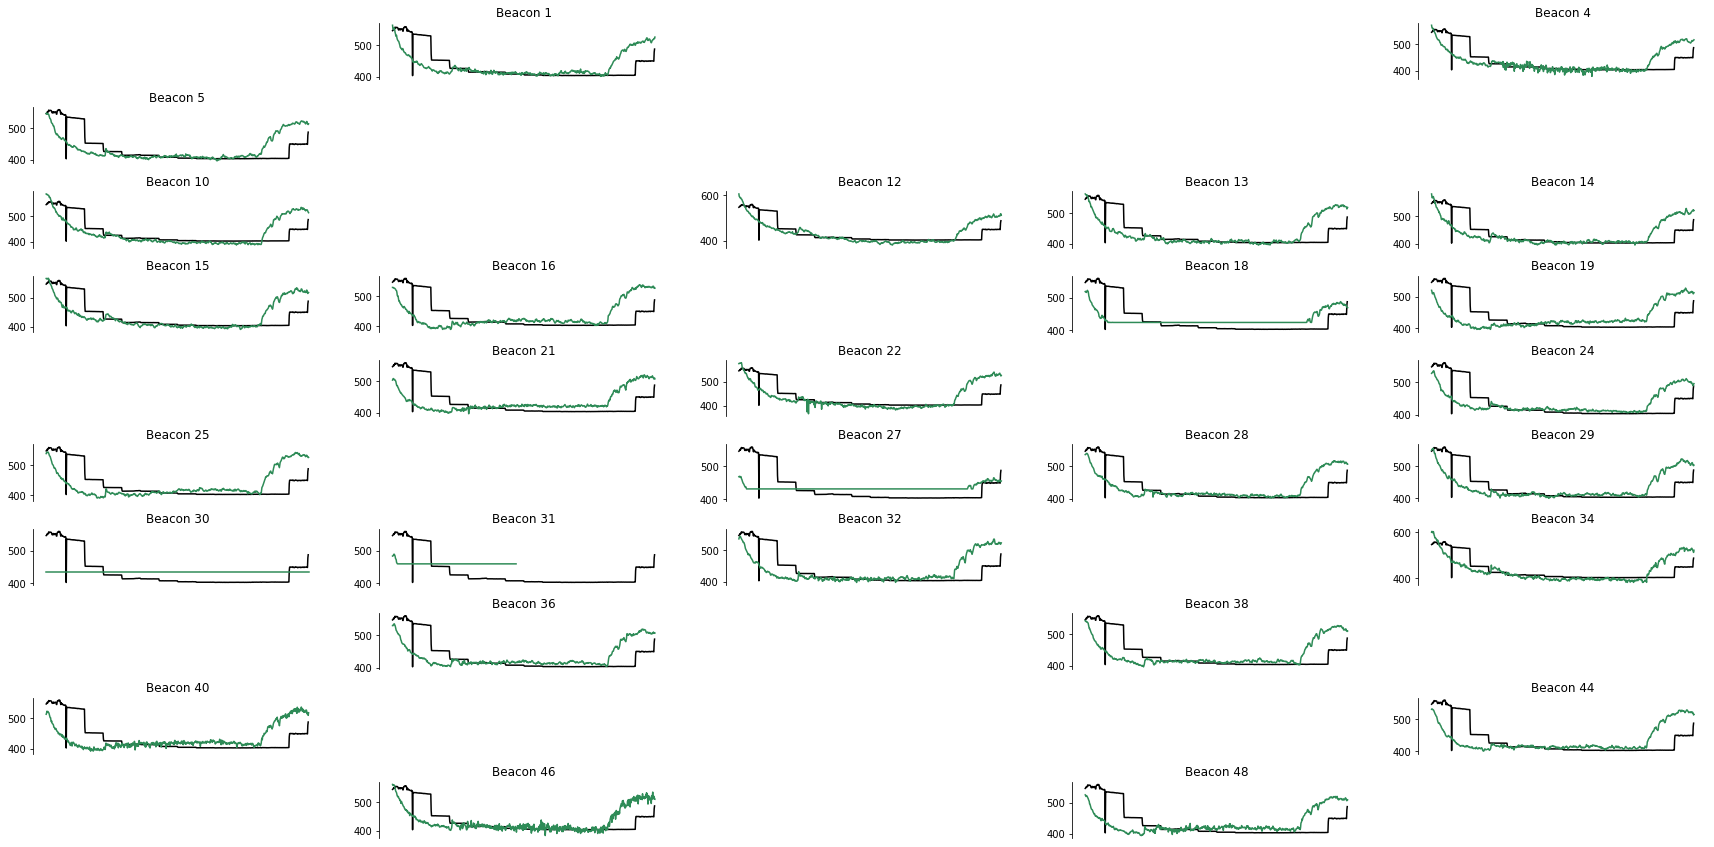

In [171]:
co2_offset = c.offset(ref, beacon, "co2", "CO2", save_to_file=True)